In [1]:
# Import libraries

import quandl
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import os
import statsmodels.api as sm
import warnings
import datetime


warnings.filterwarnings("ignore")

plt.style.use('fivethirtyeight')

In [2]:
quandl.ApiConfig.api_key = 'c3iuHrxR2TsrnxyXi_vb'

In [4]:
# Zillow contains 3 different variables:
# ZILLOW/DATA - Prices of houses including date of sale
# ZILLOW/INDICATORS - Type of home
# ZILLOW/REGIONS - Region of home

# Because we're working with time series data, let's focus on the first one
# Retrieve the data
data = quandl.get_table("ZILLOW/DATA")

# I want the date range for my data to be congruent with my original dataset
# Filtering the data for the time ranges below

# Convert the 'date' column to datetime
data['date'] = pd.to_datetime(data['date'])

# Filter the data within the specified timeframe
start_date = pd.Timestamp('2010-11-01')
end_date = pd.Timestamp('2017-01-01')
filtered_data = data[(data['date'] >= start_date) & (data['date'] <= end_date)]

# Print the filtered data to verify the result
print(filtered_data)

     indicator_id region_id       date     value
None                                            
76           ZSFH     99999 2016-12-31  287447.0
77           ZSFH     99999 2016-11-30  286670.0
78           ZSFH     99999 2016-10-31  285541.0
79           ZSFH     99999 2016-09-30  284428.0
80           ZSFH     99999 2016-08-31  282233.0
...           ...       ...        ...       ...
9917         ZSFH     99958 2011-03-31   67330.0
9918         ZSFH     99958 2011-02-28   67318.0
9919         ZSFH     99958 2011-01-31   67087.0
9920         ZSFH     99958 2010-12-31   67910.0
9921         ZSFH     99958 2010-11-30   68761.0

[3020 rows x 4 columns]


In [5]:
filtered_data.head(5)

,indicator_id,region_id,date,value
None,,,,
76,ZSFH,99999,2016-12-31,287447.0
77,ZSFH,99999,2016-11-30,286670.0
78,ZSFH,99999,2016-10-31,285541.0
79,ZSFH,99999,2016-09-30,284428.0
80,ZSFH,99999,2016-08-31,282233.0


In [6]:
filtered_data.shape

(3020, 4)

In [7]:
filtered_data.columns

Index(['indicator_id', 'region_id', 'date', 'value'], dtype='object')

In [8]:
type(filtered_data)

pandas.core.frame.DataFrame

In [9]:
# Create a subset of the data

data_dates = filtered_data[['date', 'value']].reset_index(drop=True)
data_dates

,date,value
0,2016-12-31,287447.0
1,2016-11-30,286670.0
2,2016-10-31,285541.0
3,2016-09-30,284428.0
4,2016-08-31,282233.0
...,...,...
3015,2011-03-31,67330.0
3016,2011-02-28,67318.0
3017,2011-01-31,67087.0
3018,2010-12-31,67910.0


In [10]:
# Arrange the data in chronological order

data_dates_sorted = data_dates.sort_values('date')
data_dates_sorted

,date,value
3019,2010-11-30,68761.0
2649,2010-11-30,198961.0
961,2010-11-30,99356.0
517,2010-11-30,117797.0
2145,2010-11-30,83378.0
...,...,...
2280,2016-12-31,291957.0
1110,2016-12-31,136762.0
1850,2016-12-31,419667.0
962,2016-12-31,365975.0


In [11]:
# Set the "date" column as the index

data_dates_sorted['datetime'] = pd.to_datetime(data_dates_sorted['date'])
data_dates_sorted = data_dates_sorted.set_index('datetime')
data_dates_sorted.drop(['date'], axis=1, inplace=True)
data_dates_sorted.head()

,value
datetime,
2010-11-30,68761.0
2010-11-30,198961.0
2010-11-30,99356.0
2010-11-30,117797.0
2010-11-30,83378.0


In [12]:
# There are multiple purchases made on the same day
# To make plotting easier, I took the median value of purchases made for a single day, along with the average

data_median = data_dates_sorted.groupby('datetime')['value'].median().reset_index()
data_average = data_dates_sorted.groupby('datetime')['value'].mean().reset_index()

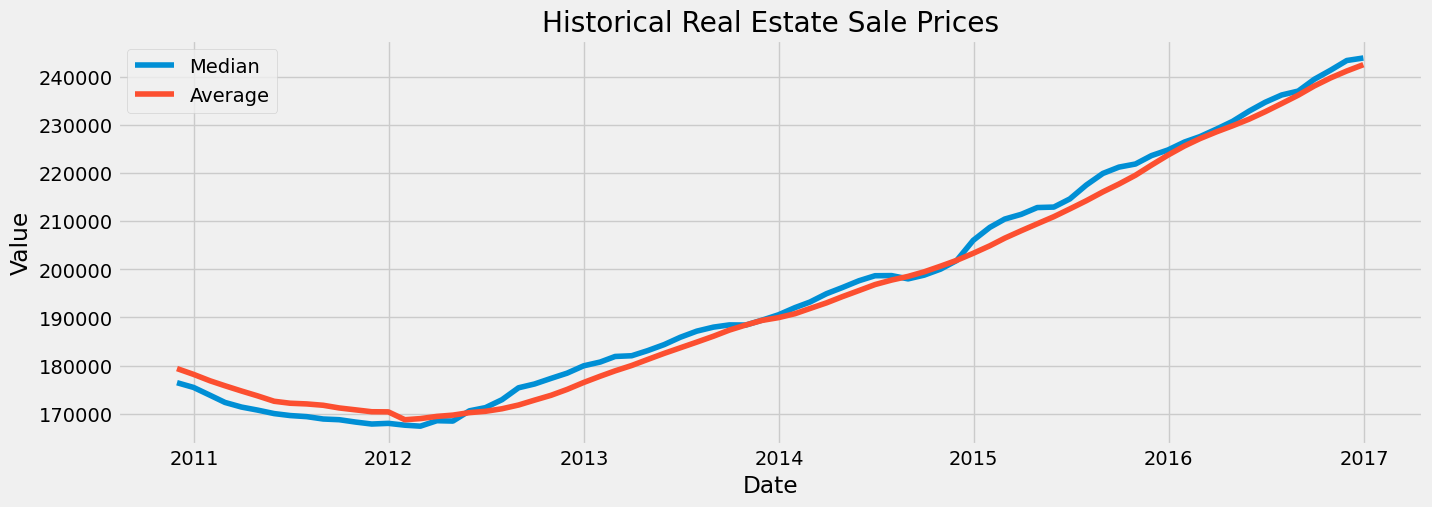

In [13]:
plt.figure(figsize=(15, 5), dpi=100)

# Plotting the median values
plt.plot(data_median['datetime'], data_median['value'], label='Median')

# Plotting the average values
plt.plot(data_average['datetime'], data_average['value'], label='Average')

# Set labels for the axes
plt.xlabel('Date')
plt.ylabel('Value')

# Set the title of the plot
plt.title('Historical Real Estate Sale Prices')

# Show a legend
plt.legend()

# Display the plot
plt.show()

In [14]:
# Check for missing values

data_dates_sorted.isnull().sum()

value    0
dtype: int64

In [15]:
# Check for duplicates

dups = data_dates_sorted.duplicated()
dups

datetime
2010-11-30    False
2010-11-30    False
2010-11-30    False
2010-11-30    False
2010-11-30    False
              ...  
2016-12-31    False
2016-12-31    False
2016-12-31    False
2016-12-31    False
2016-12-31    False
Length: 3020, dtype: bool

In [16]:
data_dates_sorted = data_dates_sorted.drop_duplicates()

In [17]:
data_dates_sorted.shape

(2998, 1)

### Decomposition

In [18]:
# Since there are rows within the data that have the same row i.e. multiple sales with the same dates, the median of the
# value of each day will be used to check the time series

data_median

,datetime,value
0,2010-11-30,176435.5
1,2010-12-31,175452.0
2,2011-01-31,173821.0
3,2011-02-28,172329.5
4,2011-03-31,171366.5
...,...,...
69,2016-08-31,237052.0
70,2016-09-30,239492.0
71,2016-10-31,241414.0
72,2016-11-30,243401.0


In [19]:
# Change the datetime as the header

data_median = data_median.set_index('datetime')

In [20]:
data_median

,value
datetime,
2010-11-30,176435.5
2010-12-31,175452.0
2011-01-31,173821.0
2011-02-28,172329.5
2011-03-31,171366.5
...,...
2016-08-31,237052.0
2016-09-30,239492.0
2016-10-31,241414.0


In [25]:
# Decompose the time series using an additive model

decomposition = sm.tsa.seasonal_decompose(data_median, model='additive') 

In [27]:
from pylab import rcParams

rcParams['figure.figsize'] = 18, 7

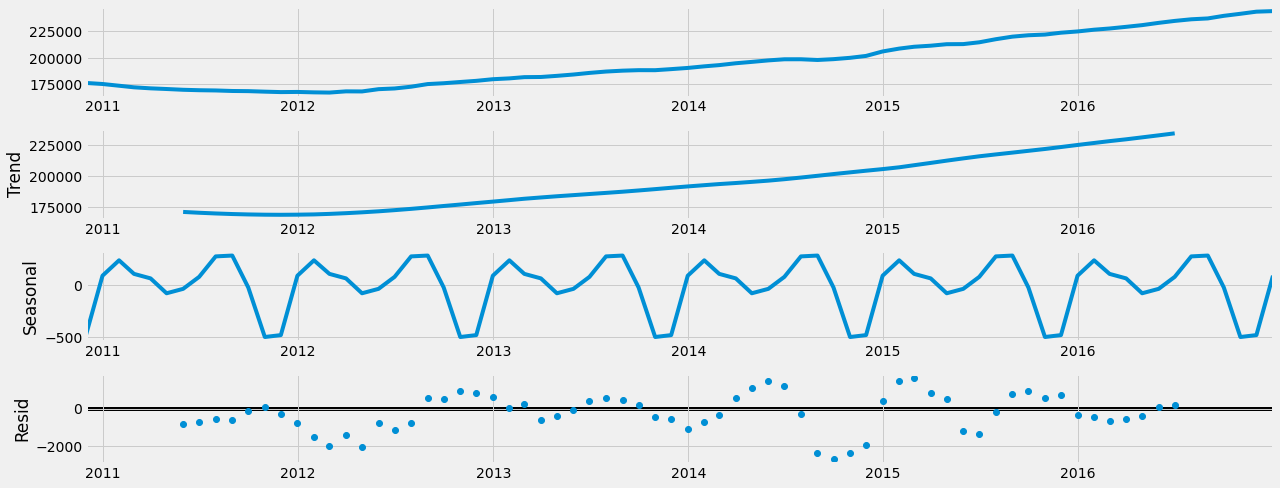

In [28]:
decomposition.plot()
plt.show()

#### The Level graph shows the median of each house sale sold for the specific day, showing that the sales price gradually goes up (but with a slight dip in house prices near 2012)
#### The Trend line follows closely to the Level graph which shows that there is not a lot of noise or fluctuations within the data
#### The Seasonality graph has a pattern that's the same for every year, which shows that the data has seasonality
#### The Residual graph has some unexplained noise that has various up and down variations

### Testing for stationarity

In [29]:
from statsmodels.tsa.stattools import adfuller

def dickey_fuller(timeseries):
    print ('Dickey-Fuller Stationarity test:')
    test = adfuller(timeseries, autolag='AIC')
    result = pd.Series(test[0:4], index=['Test Statistic','p-value','Number of Lags Used','Number of Observations Used'])
    for key,value in test[4].items():
       result['Critical Value (%s)'%key] = value
    print (result)

dickey_fuller(data_median['value'])

Dickey-Fuller Stationarity test:
Test Statistic                  1.643273
p-value                         0.997982
Number of Lags Used             1.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


#### The test statistic is much higher than the critical value, so we cannot reject the null hypothesis.
#### The data is non-stationary
#### The p-value is also incredibly high, which isn't surprising because of all the noise within the seasonlity graph

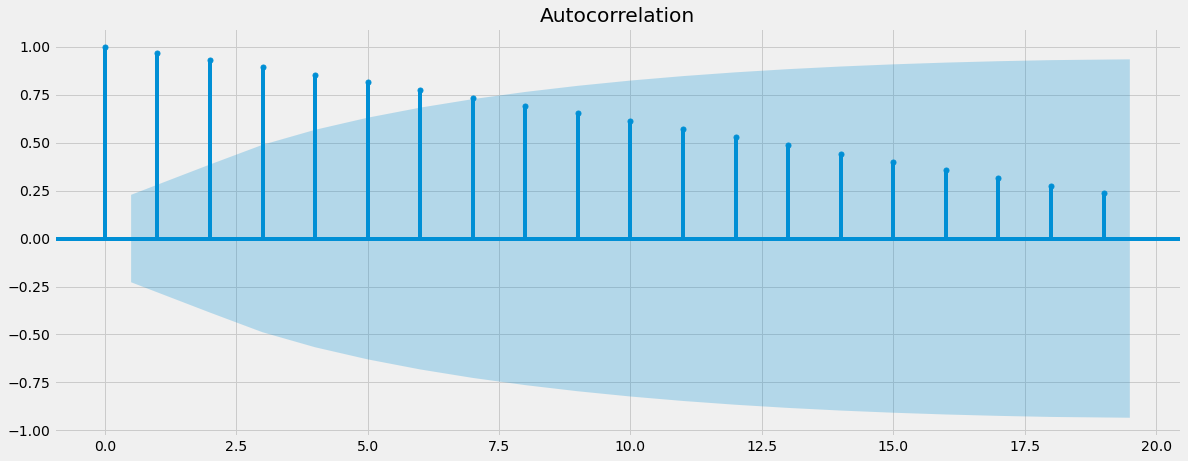

In [30]:
# Check out a plot of autocorrelations

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf # Here, you import the autocorrelation and partial correlation plots

plot_acf(data_median)
plt.show()

#### There are many vertical lines that go above the confidence interval, represented by the blue area. The autocorrelated data is likely non-stationary, which was also found to be true from the Dickey-Fuller test

### Stationarizing the data

In [31]:
data_diff = data_median - data_median.shift(1) # The df.shift(1) function turns the observation to t-1, making the whole thing t - (t -1)

In [32]:
# Here, you remove the missing values that came about as a result of the differencing. 
# You need to remove these or you won't be able to run the Dickey-Fuller test.

data_diff.dropna(inplace=True)

In [33]:
data_diff.head()

,value
datetime,
2010-12-31,-983.5
2011-01-31,-1631.0
2011-02-28,-1491.5
2011-03-31,-963.0
2011-04-30,-626.5


In [36]:
data_diff.columns

Index(['value'], dtype='object')

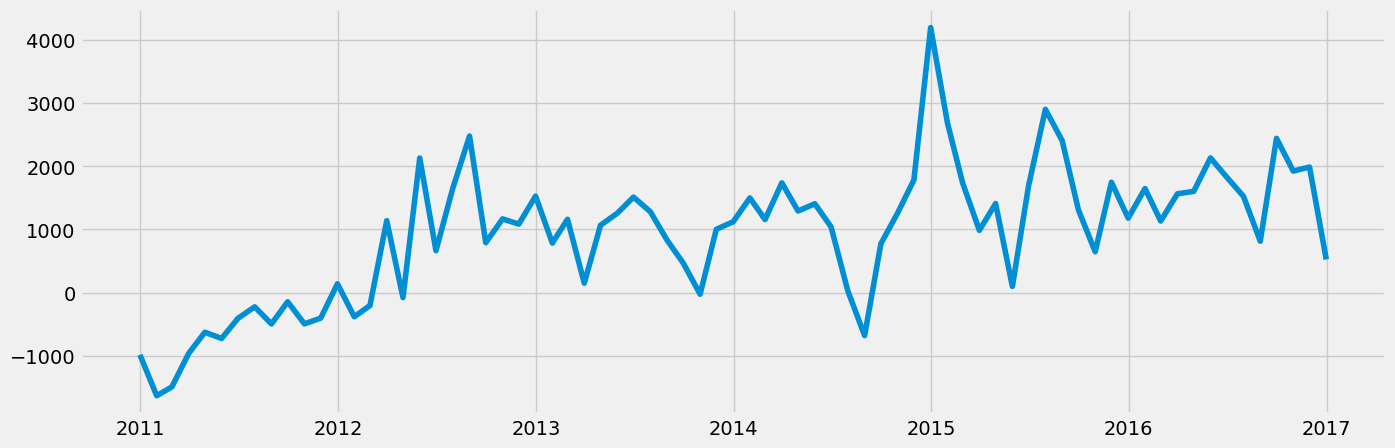

In [37]:
# Plot the data after differencing

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff)

In [38]:
dickey_fuller(data_diff)

Dickey-Fuller Stationarity test:
Test Statistic                 -3.876254
p-value                         0.002217
Number of Lags Used             0.000000
Number of Observations Used    72.000000
Critical Value (1%)            -3.524624
Critical Value (5%)            -2.902607
Critical Value (10%)           -2.588679
dtype: float64


##### Previous results:

#### Test Statistic                  1.643273
#### p-value                         0.997982
#### Number of Lags Used             1.000000
#### Number of Observations Used    72.000000
#### Critical Value (1%)            -3.524624
#### Critical Value (5%)            -2.902607
#### Critical Value (10%)           -2.588679

### The new results after differencing look much better: the test statistic is smaller than the critical value at all percentages, with a p value of <0.05, thus rejecting the null hypothesis

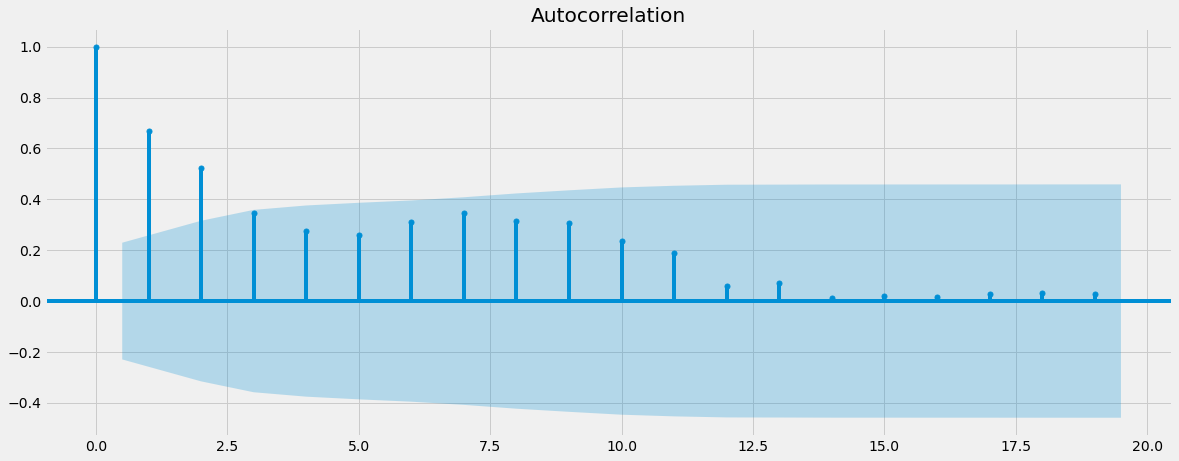

In [39]:
plot_acf(data_diff)
plt.show()

### The resulting autocorrelation shows more lines within the autocorrelation level, but with with stationarity. Let's try another round of differencing to see how the results look

In [43]:
data_diff2 = data_diff - data_diff.shift(1)

In [44]:
data_diff2.dropna(inplace=True)

In [48]:
data_diff2.head()

,value
datetime,
2011-01-31,-647.5
2011-02-28,139.5
2011-03-31,528.5
2011-04-30,336.5
2011-05-31,-98.5


In [46]:
data_diff2.columns

Index(['value'], dtype='object')

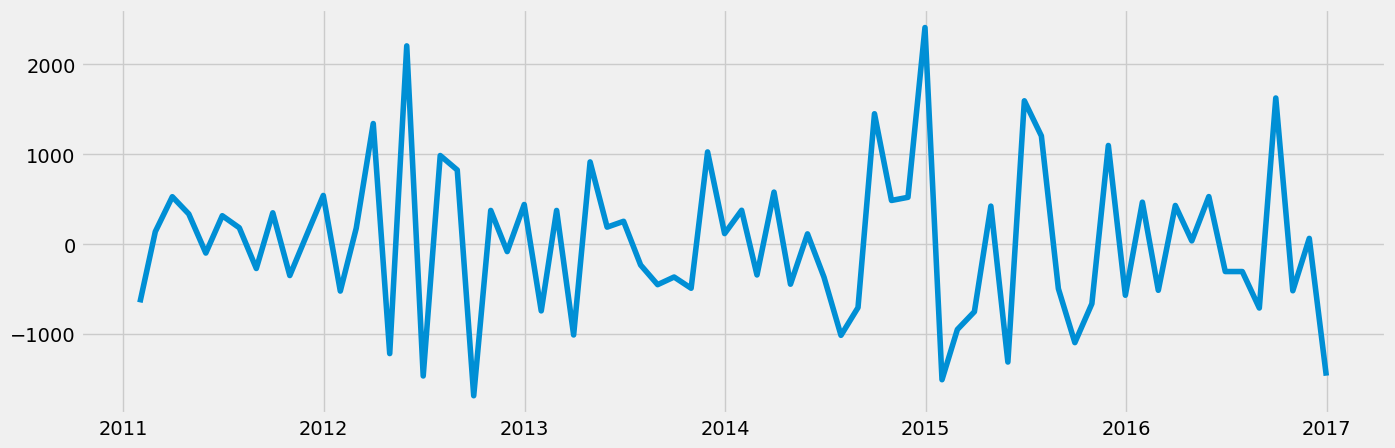

In [47]:
# Plot the data after differencing

plt.figure(figsize=(15,5), dpi=100)
plt.plot(data_diff2)

In [49]:
dickey_fuller(data_diff2)

Dickey-Fuller Stationarity test:
Test Statistic                -5.826204e+00
p-value                        4.073816e-07
Number of Lags Used            5.000000e+00
Number of Observations Used    6.600000e+01
Critical Value (1%)           -3.533560e+00
Critical Value (5%)           -2.906444e+00
Critical Value (10%)          -2.590724e+00
dtype: float64


### Now the test statistic is even lower than the critical values, as well as a smaller p-value

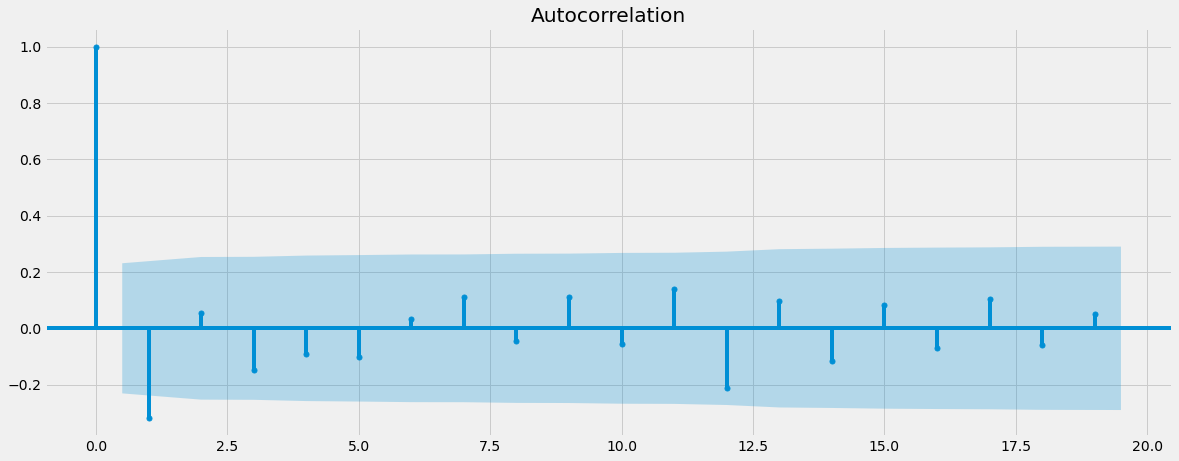

In [50]:
plot_acf(data_diff2)
plt.show()

### The autocorrelation also has almost all the values within the confidence interval